## 3-D field scanner: Using a Raspberry Pi Pico to trigger magnetic field sensor and photosensor measurements.

## Purpose.
In this notebook, we will give a detailed explanation on how to take magnetic field measurements, that can be triggered using a outside power source, with a unstable voltage.
## Steps.
1. Install Thonny and connecting Raspberry Pi Pico.
2. Build the needed circuitry.
3. Explanation of code.
4. Measurement taking process.


# Thonny.
In order for you to communicate with the Raspberry Pi Pico, you will need to install a Micro Python IDE called 'Thonny'. Go to https://thonny.org/ and follow the instructions.

## Connecting and Configuring Raspberry Pi Pico.
Once Thonny has been installed, it is time to connect the Raspberry Pi Pico. Follow these steps:
1. While holding the bootsel button on the Raspberry Pi Pico, insert the usb cable into your PC. Once inserted you can let go of the button. If you did this collectly, you should see that there is a new device called RPI-RP2 in your devices list.
2. Open Thonny and go to Run>Configure Interpreter...
   You should be met with the following screen:




<div>
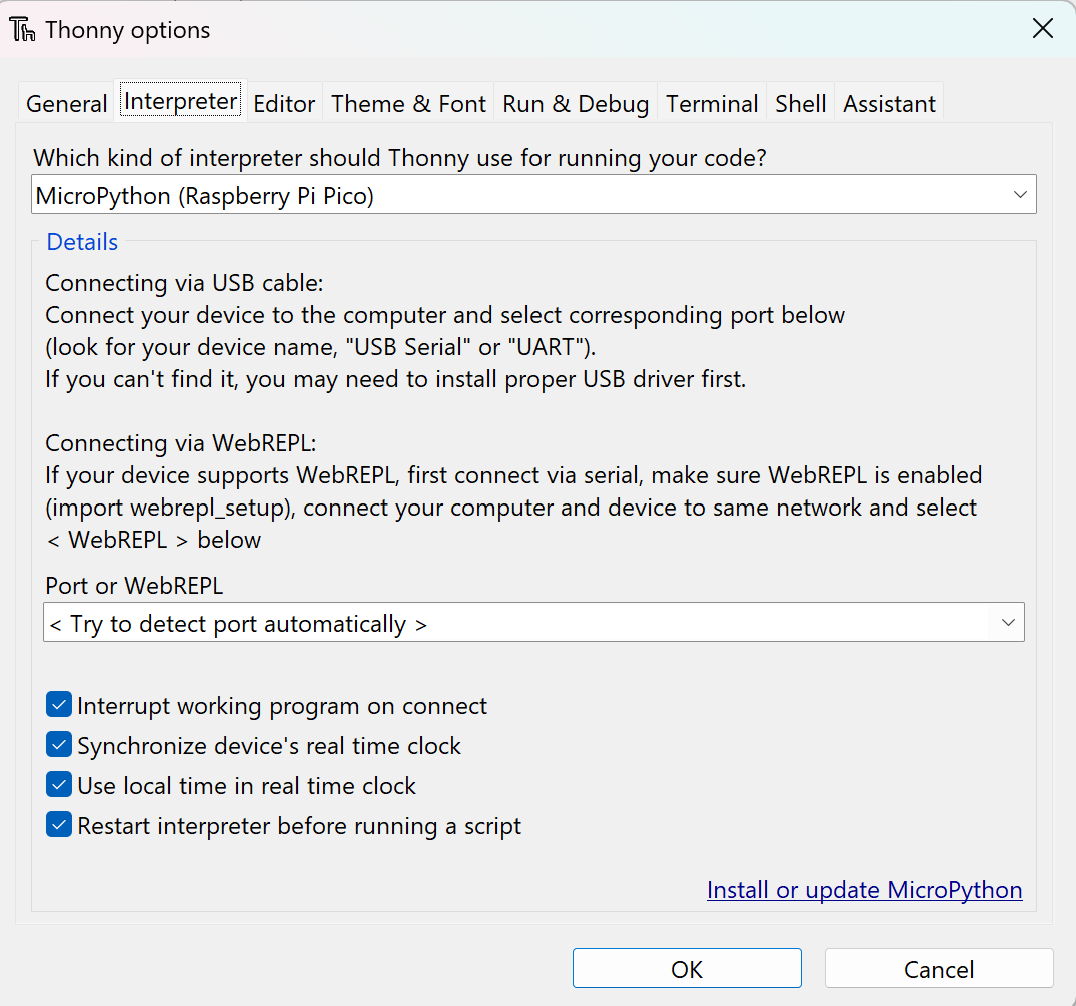
</div>

3. Make sure all settings are the same as in the figure and click on 'Install or update MicroPython.
   You should be met with the following screen:



<div>
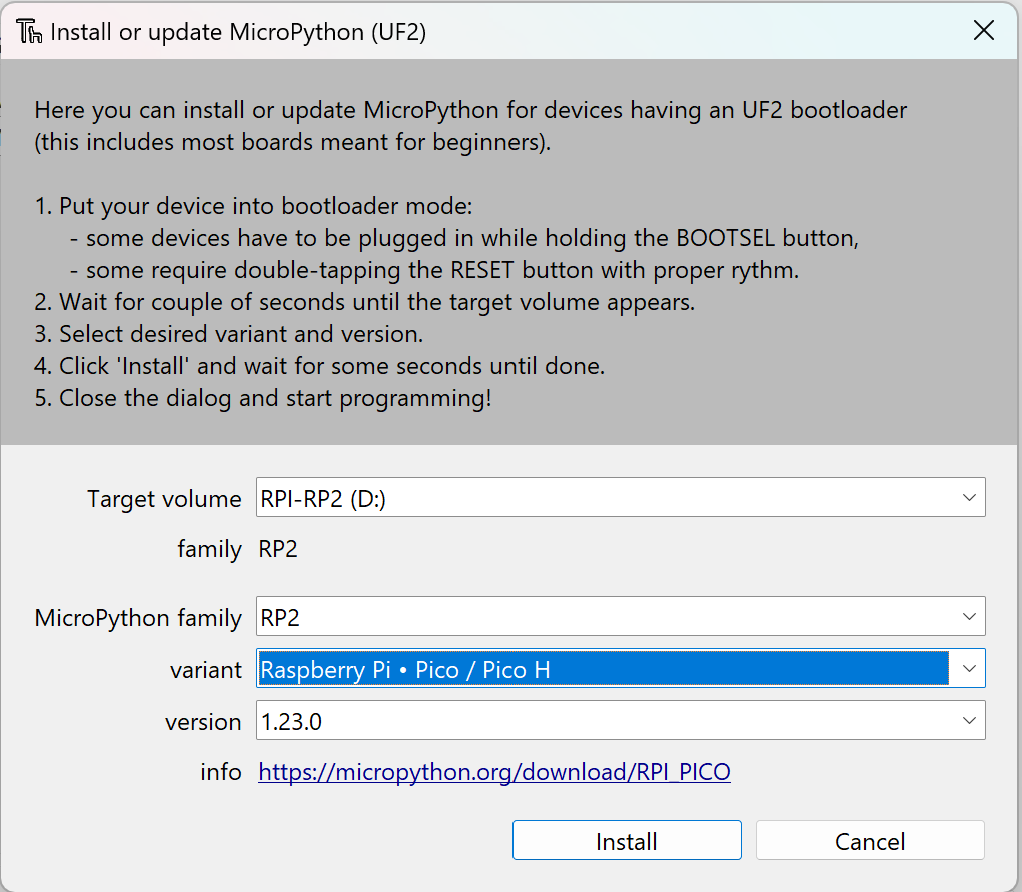
</div>

4. Make sure you have the same setting and click install. After this your micropython is ready to run.

# Making of circuitry.

In this part, we provide the circuit schematic used in our project. It has been split into three diagrams, so all parts can be sufficiently explained.

The first circuit, given below, shows the schematic that allows you to safely connect a variable powersource (In our case the fan output of a 3-D printer). 
The resistor of 270 Ω is chosen at this specific resistance, since the original fan that came with the printer also had a resistance of 270 Ω.


A bit more explaining is necessary for you to know why we made this circuit the way we did. We want to be able to trigger a measurent when the external power source is turned on. However, this voltage can exceed the 3.3 V the Raspberry Pi Pico can safely handel. By seperating the two circuits and placing an LED and LDR between the two, we prevent the Raspberry Pi Pico from breaking. As the powersource turns on, the LED lights up, making the resistance of the LDR go down, which we can use as a trigger for a digital GPIO pin.
Important to note is that the LED and LDR schould be sealed together from stray light in order for this method to work.

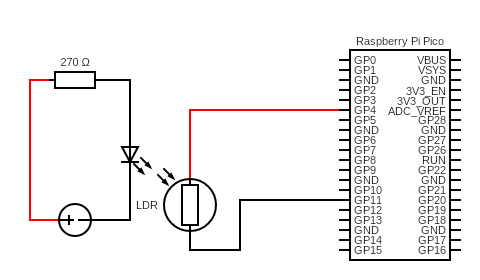


The next circuit diagram, which you can find below, shows how to connect an LDR to the Raspberry Pi Pico. As you can see, the LDR is connected to and ADC (analog to digital converter) GPIO pin 26. This part of our circuit will be used as a photosensor, which will be used to determine the speedprofile of our robotic arm. 

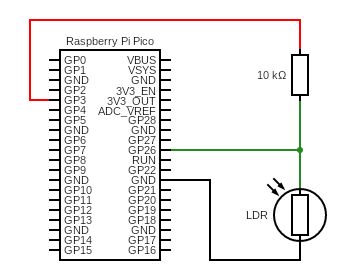

Finally, the last diagram below shows how to connect the TMAG5273 Hall sensor, which we use to take magnetic field strength measurements.


<div>
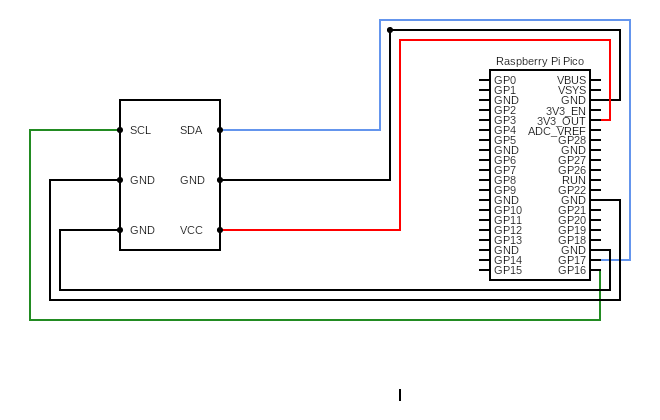
</div>

Our final circuit looked like this:

<div>
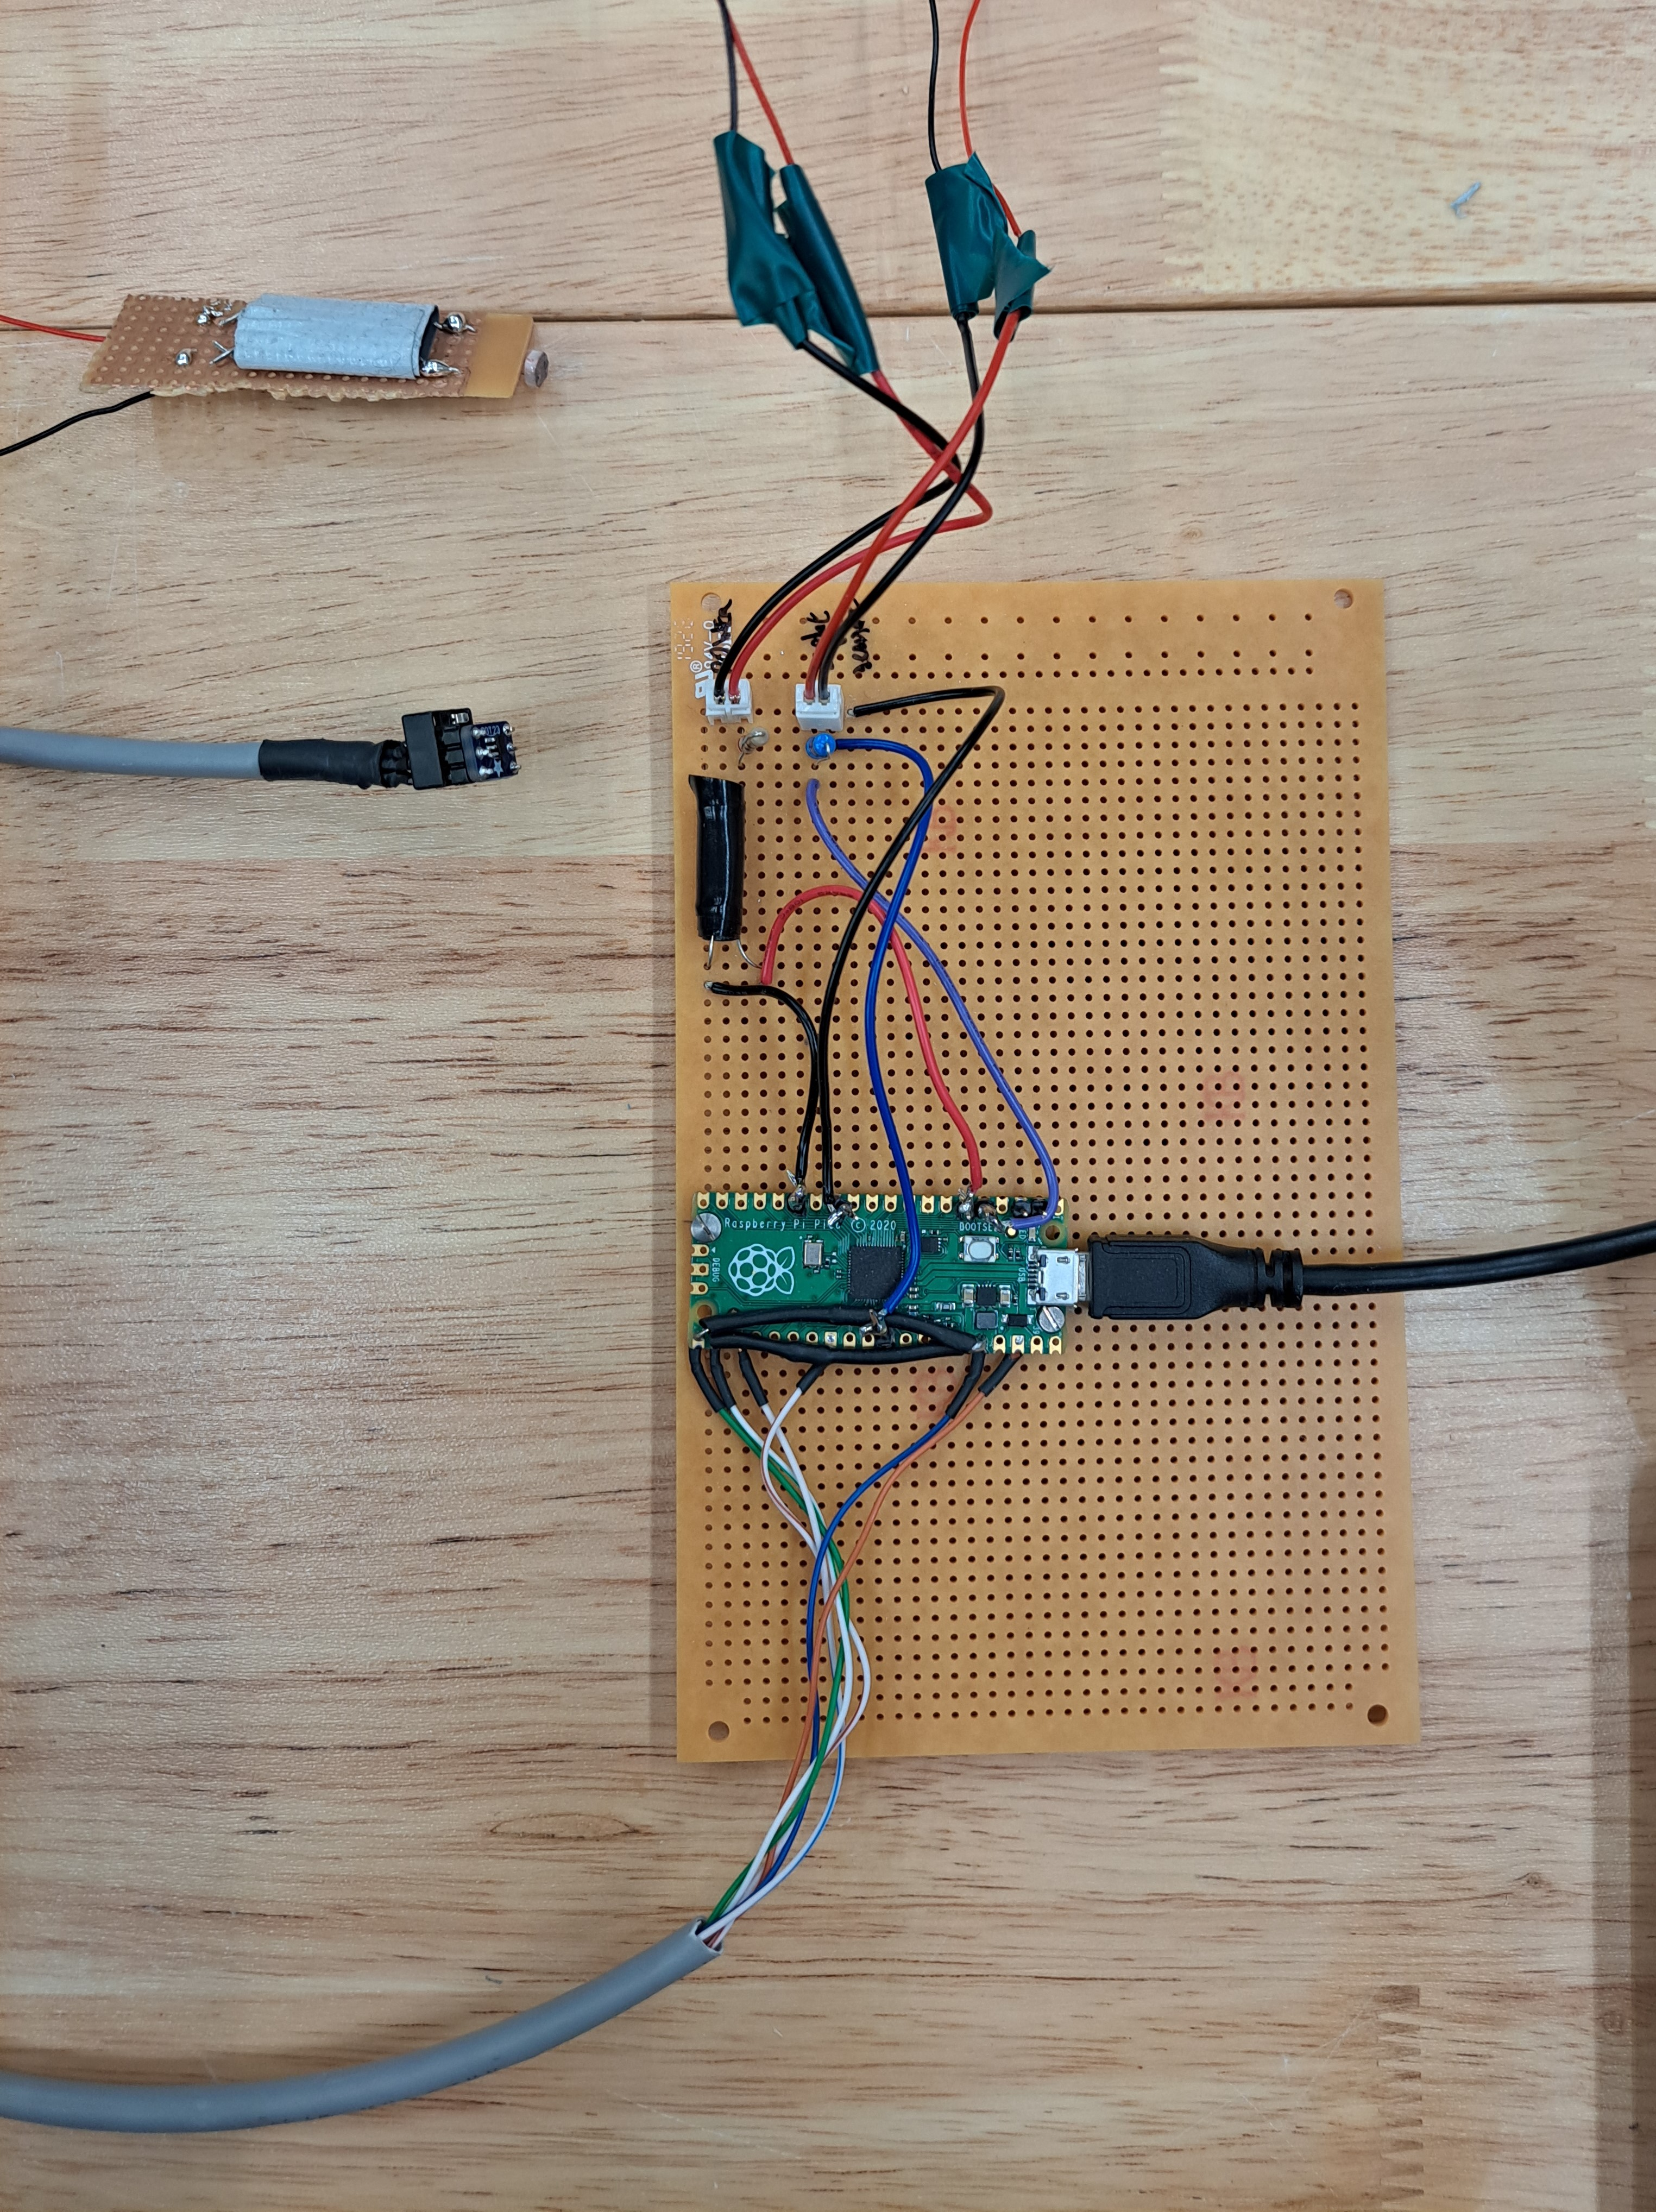
</div>

One thing to notice is the black part. This is the LED and LDR, taped together with black tape, inorder to prevent stray light from effecting the LDR. This could be further improved by completely lightsealing the LED and LDR.

# Explanation code.

In this part, we will look at two codes and explain what they do. The first one will be the code where we measure the voltage on GPIO pin 26, i.e. the photodectector measurements. In the second code, we measure magnetic field measurements.

Some key things to note:

1. When a GPIO pin is turned on as an output pin, it gives you 3.3V output. 
2. An input pin is turned on when it receives a voltage greater than 1.8V.
3. Since the robotic arm fan does not give a stable voltage, we can't keep a GPIO input pin stably on. In order to get around this problem, we use two loop that run simutanously, where one starts running when the first trigger pulse is given and the other makes sure the first loop stops when the second trigger pulse is given. For this we use the _Threads library.
4. These codes need to be ran in Thonny, after the steps in 2. are completed.


## Photosensor code.


The following code  allows you to take time-stamped Voltage measurement. In our case, this is used to measure relative light intensity using the photosensor circuit given before.

Some importing things to note:

1. If you run this code using the same file name as a previous measurement, your file will be overwritten.
2. A there are a couple of variables given, which are explained in the code comments. The values they have now are specifically tuned to our 3-D printer fan output. If another powersource is used, it will require some testing to tune the code variables.
3. After your measurements is complete, stop the code manually by clicking the STOP button in Thonny, disconnect and reconnect the Raspberry Pi Pico and save the measurement file to your own computer.

In [89]:
import _thread
import time
from machine import Pin, I2C

## Variables:
time_threshold = 3  # Time interval to wait before allowing input to stop the loop. This prevents the loop from stopping imidiatly after starting, as the powersource will still be on.
output_file_name = 'V_TEST.log' #Name of file where measurements are written to.
dt = 0.01 # Time between measurements.
minimal_length_impuls = 0.01 #Time interval in which to check the trigger pin.
printer_stand_still= 1 #In the printer code, you have to stop the arm after fan starts, so this is to compensate for that.

loop1_running = False
last_transition_time = None  # Track the time of the last 0-to-1 transition
lock = _thread.allocate_lock()  # Lock for thread synchronization

# Pin object for controlling onboard LED
led = Pin("LED", Pin.OUT)

# Pin for I2C communication
sdaPIN = Pin(16)
sclPIN = Pin(17)
adc = machine.ADC(Pin(26, mode=Pin.IN))

# Pin for the trigger signal
trig = Pin(11, Pin.IN, Pin.PULL_DOWN)
powersource = Pin(4, Pin.OUT)
powersource.on()
powersource1= machine.Pin(3, machine.Pin.OUT)
powersource1.on()


# Function to write header to the log file
def write_header():
    with open(output_file_name, 'w') as f:  # Use 'w' to overwrite the file
        f.write("t  V \n")

# Monitor the signal (Trigger signal) in the main thread
def monitor_signal():
    global loop1_running, last_transition_time
    
    while True:
        if trig.value() == 1:
            current_time = time.time()
            # Start Loop 1 if not running
            if not loop1_running:
                lock.acquire()
                loop1_running = True
                last_transition_time = current_time
                lock.release()
                print("Measuring started")
                # Start loop1 in a new thread
                _thread.start_new_thread(loop1, ())
                
            
            # Stop Loop 1 after time threshold
            elif loop1_running and (current_time - last_transition_time >= time_threshold):
                lock.acquire()
                loop1_running = False
                print("Measuring stopped")
                last_transition_time = None  # Reset transition time
                lock.release()
            
            time.sleep(time_threshold)  # Debounce delay
        
        time.sleep(minimal_length_impuls)  # Short delay to avoid rapid polling for second start

# Main data collection loop
def loop1():
    global loop1_running
    t = 0  # Start timestamp relative to loop start
    time.sleep(printer_stand_still)
    with open(output_file_name, 'a') as f:# Open the file once in append mode
        f.write("\n")
        while loop1_running:
            start = time.time()  # Record start time of the iteration
            led.value(1)  # Turn on the LED (for visualization)
            
            
            val = adc.read_u16()
            val = val * (3.3 / 65535)
            print(round(t,1),round(val, 3), "V")
            # Write data to file with timestamp
            f.write("{:+05f} {:+05f}\n".format(t,val))
               
            
         
            # Calculate elapsed time and update timestamp
            elapsed = time.time() - start
            t += elapsed
            t += dt
            # Wait for the next sampling point
            time.sleep(dt)
        
        led.value(0)  # Turn off the LED after loop stops
        print("Loop 1 finished")
        
        

# Main function
def main():
    write_header()  # Write header to log file
    monitor_signal()  # Start monitoring signal in the main thread

# Run the main function
main()

ModuleNotFoundError: No module named 'machine'

## Magnetic field sensor code.
The following code allows you to take time-stamped magnetic field measurements in the x,y and z direction. The same notes as before apply for this code.

Some additional notes:
1. The unit of these magnetic field measurements have not been taken into account by us, since for the project we were working on, we only wanted to measure the inhomogeneity of the field.
2. Part of this code, related to communicating with the TMAG5273 Hall sensor, have been taken from a code provided by Driessen, A.T.W., who also made the circuit that connects the TMAG5273 Hall sensor to the Raspberry Pi Pico.

In [ ]:
import _thread
import time
from machine import Pin, I2C

## Variables:
time_threshold = 3  # Time interval to wait before allowing input to stop the loop. This prevents the loop from stopping imidiatly after starting, as the powersource will still be on.
output_file_name = 'TEST.log' #Name of file where measurements are written to.
dt = 0.01 # Time between measurements.
minimal_length_impuls = 0.01 #Time interval in which to check the trigger pin.
printer_stand_still= 1 #In the printer code, you have to stop the arm after fan starts, so this is to compensate for that.

loop1_running = False
last_transition_time = None  # Track the time of the last 0-to-1 transition
lock = _thread.allocate_lock()  # Lock for thread synchronization

# Pin object for controlling onboard LED
led = Pin("LED", Pin.OUT)

# Pin for I2C communication
sdaPIN = Pin(16)
sclPIN = Pin(17)
i2c = I2C(0, sda=sdaPIN, scl=sclPIN, freq=210000)

# Pin for the trigger signal
trig = Pin(11, Pin.IN, Pin.PULL_DOWN)
powersource = Pin(4, Pin.OUT)
powersource.on()

# I2C sensor address
addr = 0x35

# Function to write header to the log file
def write_header():
    with open(output_file_name, 'w') as f:  # Use 'w' to overwrite the file
        f.write("t  x  y  z\n")

# Initialize sensor
def init_sensor():
    i2c.writeto(addr, b'\x00\x20')  # Device config 1
    i2c.writeto(addr, b'\x01\x22')  # Device config 2
    i2c.writeto(addr, b'\x02\x79')  # Sensor config 1
    i2c.writeto(addr, b'\x07\x01')  # Temp config

# Monitor the signal (Trigger signal) in the main thread
def monitor_signal():
    global loop1_running, last_transition_time
    
    while True:
        if trig.value() == 1:
            current_time = time.time()
            # Start Loop 1 if not running
            if not loop1_running:
                lock.acquire()
                loop1_running = True
                last_transition_time = current_time
                lock.release()
                print("Measuring started")
                # Start loop1 in a new thread
                _thread.start_new_thread(loop1, ())
                
            
            # Stop Loop 1 after time threshold
            elif loop1_running and (current_time - last_transition_time >= time_threshold):
                lock.acquire()
                loop1_running = False
                print("Measuring stopped")
                last_transition_time = None  # Reset transition time
                lock.release()
            
            time.sleep(time_threshold)  # Debounce delay
        
        time.sleep(minimal_length_impuls)  # Short delay to avoid rapid polling for second start

# Main data collection loop
def loop1():
    global loop1_running
    t = 0  # Start timestamp relative to loop start
    time.sleep(printer_stand_still)
    with open(output_file_name, 'a') as f:# Open the file once in append mode
        f.write("\n")
        while loop1_running:
            start = time.time()  # Record start time of the iteration
            led.value(1)  # Turn on the LED (for visualization)
            
            print(t)
            s = i2c.readfrom_mem(addr, 0x12, 0x17)  # Read Hall effect sensor data
            x = ((s[0x12-0x12] << 4) + (s[0x13-0x12] >> 4))
            y = ((s[0x14-0x12] << 4) + (s[0x15-0x12] >> 4))
            z = ((s[0x16-0x12] << 4) + (s[0x17-0x12] >> 4))
                
                # Adjust negative values
            if x > 2048:
                x -= 4096
            if y > 2048:
                y -= 4096
            if z > 2048:
                z -= 4096
                
                # Write data to file with timestamp
            f.write(f"{t:.3f} {x:+03d} {y:+03d} {z:+03d}\n")
         
            # Calculate elapsed time and update timestamp
            elapsed = time.time() - start
            t += elapsed
            t += dt
            # Wait for the next sampling point
            time.sleep(dt)
        
        led.value(0)  # Turn off the LED after loop stops
        print("Loop 1 finished")
        
        

# Main function
def main():
    write_header()  # Write header to log file
    init_sensor()  # Initialize the sensor
    monitor_signal()  # Start monitoring signal in the main thread

# Run the main function
main()

# Measurement taking process.
In this section, we explain the process of taking measurements, since this is somewhat user unfriendly.

In order to take a measurement, you need to these steps:
1. Follow the steps given in 1.1.
2. Run one of the two codes provided in 3.
3. After your measurements is complete, stop the code manually by clicking the STOP button in Thonny. It will appear as if the Raspberry Pi Pico crashed, this is normal. Save the measurement file to your own computer AFTER disconnecting and reconnecting the usb connection. Otherwise your data might be lost!!!
4. Disconnect the Raspberry Pi Pico by disconnection the usb connection.

Some notes and throubleshooting:
- If step 1 does not leave you with a connection to the Raspberry Pi Pico, disconnect the Raspberry Pi Pico and repeat. This happens sometimes.
- When you want to take a new measurement, repeat ALL steps. The Raspberry Pi Pico MUST be reconnected, otherwise it will not work.
- When you want to take a new measurement, change the name of your file name to avoid conflicts.